In [1]:
import numpy as np
# import matplotlib.pyplot as plt

import sys
sys.path.append("./")
sys.path.append("./../")
sys.path.append("./../models")
sys.path.append("./../../")

from simulation.envs.TWLRobot import TWLRobot, TWLRobotDisc


termination_time = 5
env = TWLRobotDisc("./../models/scene.xml", 1, termination_time, 2, obs_noise=0)
env.render_mode = "human"
env.reset()
env.sample_goal()

In [2]:
print(env.calculate_reward())
env.goal = np.array([1,0,env.data.qpos[2]])
env.goal_orientation = np.eye(3)
print(env.calculate_reward())

(-0.9, {'reward_position': 0, 'reward_position_bias': 0, 'reward_stall': -1, 'reward_face_goal': 0.9999999999999999})
(-0.9, {'reward_position': 0, 'reward_position_bias': 0, 'reward_stall': -1, 'reward_face_goal': 1.0})


In [3]:
import copy
import torch
from torch.autograd import Variable
import random
import math
# import torchvision.transforms as T
import numpy as np
import time

In [4]:
class DQN():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=12, alpha=0.001):
            self.criterion = torch.nn.MSELoss()
            self.model = torch.nn.Sequential(
                torch.nn.Linear(state_dim, hidden_dim),
                torch.nn.LeakyReLU(),
                torch.nn.Linear(hidden_dim, action_dim),
            )
            self.optimizer = torch.optim.Adam(self.model.parameters(), alpha)

            self.losses = []

    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))

        self.losses.append(loss.detach().numpy())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))

    def replay(self, memory, size, gamma):
      if len(memory) < size:
        return

      batch = random.sample(memory, size)

      batch_t = list(map(list, zip(*batch)))

      dones = batch_t[4]
      states = torch.Tensor(batch_t[0])
      actions = torch.LongTensor(batch_t[1])
      next_states = torch.Tensor(batch_t[2])
      rewards = torch.Tensor(batch_t[3])
      dones_tensor = torch.Tensor(batch_t[4])

      is_done_indices = torch.where(dones_tensor==True)[0]

      all_q_values = self.model(states)
      all_q_values_next = self.model(next_states)
      all_q_values[range(len(all_q_values)),actions.tolist()] = rewards + gamma*torch.max(all_q_values_next, axis = 1).values
      all_q_values[is_done_indices.tolist(), actions[dones].tolist()] = rewards[is_done_indices.tolist()]
      self.update(states, all_q_values)


/tmp/ipykernel_172871/973848395.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.Tensor(batch_t[0])


done


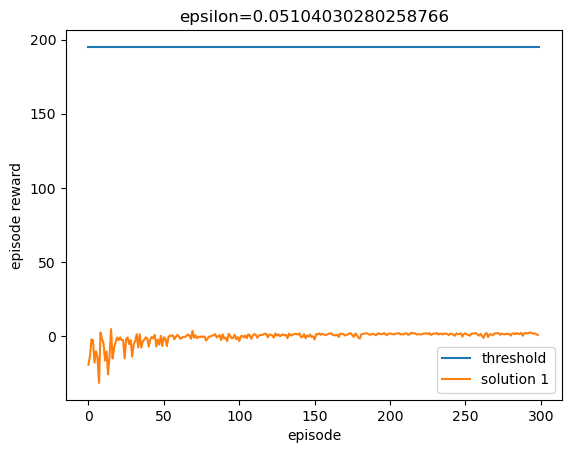

In [5]:
import numpy as np
import matplotlib.pyplot as plt
# Q table
n_states = env.observation_space.shape[0]
n_actions = 5 # Actions

# Learning Parameters
epsilon = 0.6 # gready threashold
alpha = 0.04 # learning rate
gamma = 0.99 # reward discount factor

# Execution parameters
SHOW_ANIMATION = False
EPISODES_MAX = 300
STEPS_MAX = 3000
DESIRED_STEPS = 2000

# Loggers
log_total_reward = np.zeros(EPISODES_MAX)
log_steps_number = np.zeros(EPISODES_MAX)

#
n_hidden = 24
model = DQN(n_states, n_actions, n_hidden, alpha)
scheduler = torch.optim.lr_scheduler.StepLR(model.optimizer, step_size=30, gamma=0.6)
#
memory = []
replay_size = 64
#
end_epsilon = 0.01
start_epsilon = 1
epsilon_decay = 0.8
# Q-learning
for i_episode in range(EPISODES_MAX):
    observation = env.reset()
    rewards = 0
    state = observation[0]

    if i_episode > 10 and (i_episode + 1) % 10 == 0:
          if epsilon > 0.2:
              epsilon = epsilon*0.89
          elif epsilon > 0.1:
              epsilon = epsilon*0.9
          elif epsilon > 0.05:
              epsilon = epsilon*0.95
          else:
              epsilon = 0.01

    # epsilon = end_epsilon + (start_epsilon - end_epsilon) * np.exp(-1 * EPISODES_MAX / (i_episode + 1) / epsilon_decay)

    if (i_episode + 1) % 50 == 0:
        plt.figure(2)
        plt.clf()

        # We say that problem is solved, if the mean length of the last 50 episodes it greater th
        plt.plot([0,i_episode], [195, 195], label="threshold")
        plt.plot(range(0,i_episode), log_total_reward[0:i_episode], label="solution 1")
        plt.xlabel('episode')
        plt.ylabel('episode reward')
        plt.legend()
        plt.title('epsilon={}'.format(epsilon))
        # display.clear_output(wait=True)
        # display.display(plt.gcf())

    for t in range(STEPS_MAX):
        q_values = model.predict(state)

        if np.random.random_sample() < epsilon:
            action = env.action_space.sample()
        else:
            action = torch.argmax(q_values).item()

        observation, reward, done, __, info = env.step(action)

        rewards += reward
        next_state = observation
        memory.append((state, action, next_state, reward, done))

        q_values_list = q_values.tolist()

        if done:
            q_values_next = model.predict(next_state)
            q_values_list[action] = reward
            model.update(state, q_values_list)
            # print('Episode finished after {} timesteps, total rewards {}'.format(t+1, rewards))
            scheduler.step()

        # Update Q-network
        if len(memory) < replay_size:
          q_values_next = model.predict(next_state)
          if done:
            q_values_list[action] = reward
          else:
            q_values_list[action] = reward + gamma * torch.max(q_values_next).item()
          model.update(state, q_values_list)
        else:
          model.replay(memory, replay_size, gamma)

        if done:
          log_total_reward[i_episode] = rewards
          log_steps_number[i_episode] = t
          break
        # Update current state
        state = next_state
print("done")